In [2]:
%matplotlib inline

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 29 14:00:37 2015

@author: alexandrebarachant

During a hand movement, the mu (~10Hz) and beta (~20Hz) oscillations are suppressed 
over the contralateral motor cortex, i.e. we can observe a reduction of the 
signal power in the corresponding frequency band. This effect is know as 
Event Related Desynchronization.

I used MNE python to epoch signal corresponding to the hand movement, by assuming that 
the hand movement occur before the 'Replace' event.

Using Common spatial patterns algorithm, i extract spatial filters that maximize 
the difference of variance during and after the movement, and then visualize the 
corresponding spectrum. 

For each subject, we should see a spot over the electrode C3 (Left motor cortex,
corresponding to a right hand movement), and a decrease of the signal power in 
10 and 20 Hz during the movement (by reference to after the movement).

Each subject has a different cortex organization, and a different apha and beta 
peak. The CSP algorithm is also sensitive to artefacts, so it could give eronous 
maps (for example subject 5 seems to trig on eye movements)

"""

import numpy as np
import pandas as pd
from mne.io import RawArray
from mne.channels import read_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs
from mne.viz.topomap import _prepare_topo_plot, plot_topomap
from mne.decoding import CSP

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score, LeaveOneLabelOut
from glob import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.signal import welch
from mne import pick_types

In [9]:
def creat_mne_raw_object(fname):
    """Create a mne raw instance from csv file"""
    # Read EEG file
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    montage = read_montage('standard_1005',ch_names)

    # events file
    ev_fname = fname.replace('_data','_events')
    # read event file
    events = pd.read_csv(ev_fname)
    events_names = events.columns[1:]
    events_data = np.array(events[events_names]).T
    
    # concatenate event file and data
    data = np.concatenate((1e-6*np.array(data[ch_names]).T,events_data))        
    
    # define channel type, the first is EEG, the last 6 are stimulations
    ch_type = ['eeg']*len(ch_names) + ['stim']*6
    
    # create and populate MNE info structure
    ch_names.extend(events_names)
    info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)
    info['filename'] = fname
    
    # create raw object 
    raw = RawArray(data,info,verbose=False)
    return raw

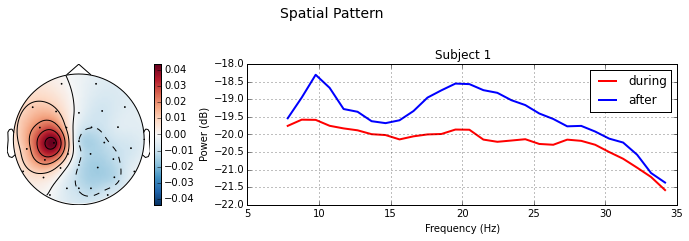

Subject 1 : AUC cross val score : 0.856


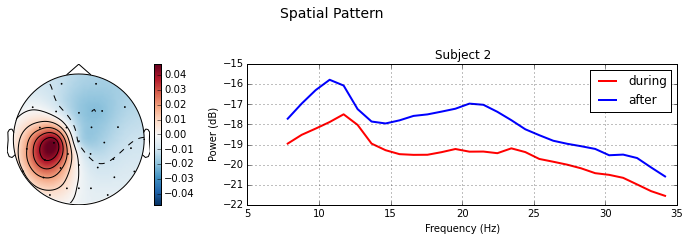

Subject 2 : AUC cross val score : 0.844


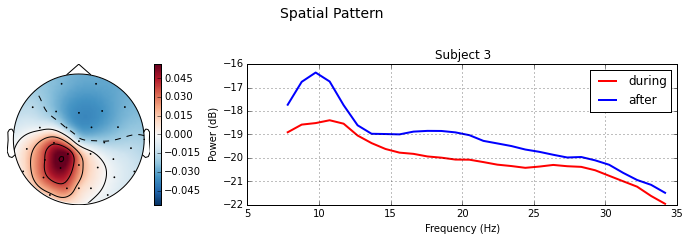

Subject 3 : AUC cross val score : 0.900


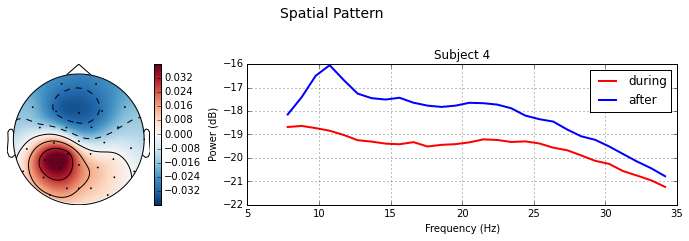

Subject 4 : AUC cross val score : 0.916


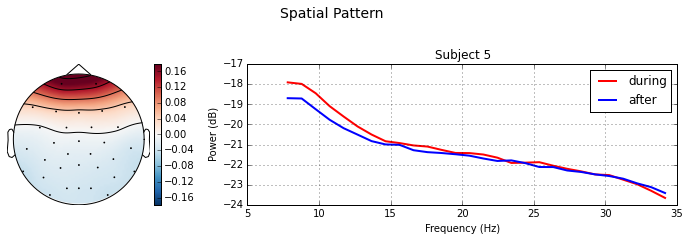

Subject 5 : AUC cross val score : 0.908


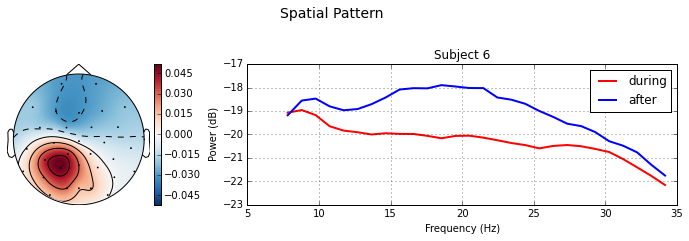

Subject 6 : AUC cross val score : 0.819


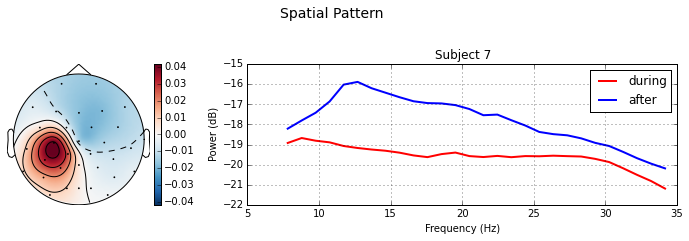

Subject 7 : AUC cross val score : 0.971


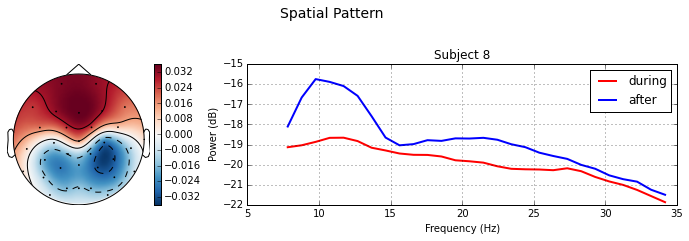

Subject 8 : AUC cross val score : 0.844


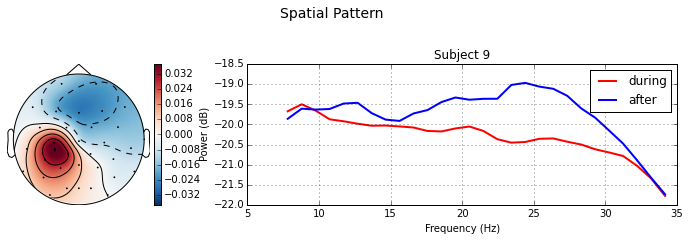

Subject 9 : AUC cross val score : 0.877


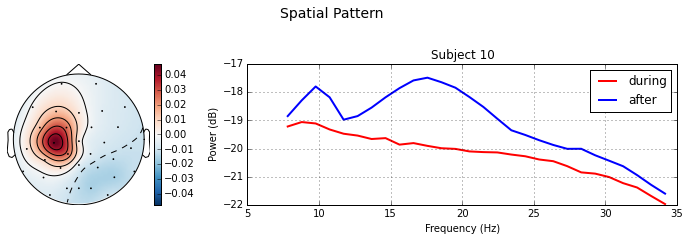

Subject 10 : AUC cross val score : 0.921


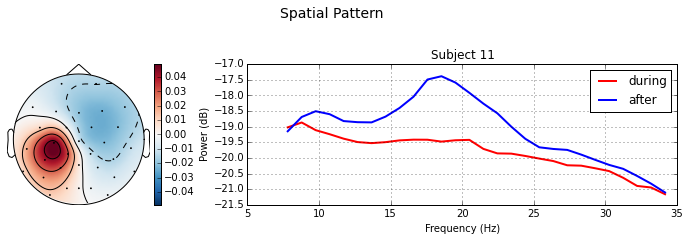

Subject 11 : AUC cross val score : 0.911


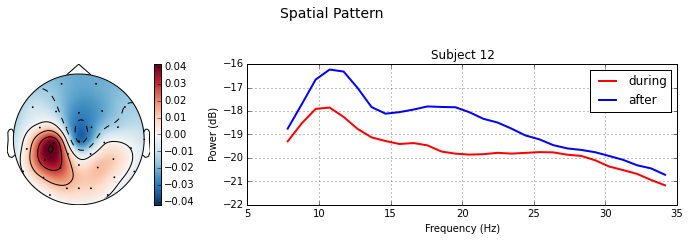

Subject 12 : AUC cross val score : 0.931


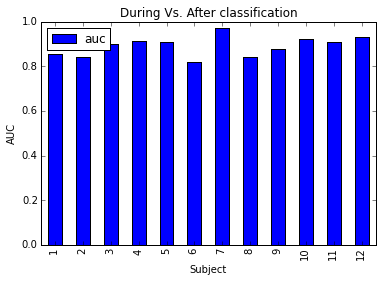

In [10]:
subjects = range(1,13)
auc = []
for subject in subjects:
    epochs_tot = []
    
    #eid = 'HandStart'
    fnames =  glob('./train/subj%d_series*_data.csv' % (subject))
    
    session = []
    y = []
    for i,fname in enumerate(fnames):
      
        # read data 
        raw = creat_mne_raw_object(fname)
        
        # pick eeg signal
        picks = pick_types(raw.info,eeg=True)
        
        # Filter data for alpha frequency and beta band
        # Note that MNE implement a zero phase (filtfilt) filtering not compatible
        # with the rule of future data.
        raw.filter(7,35, picks=picks, method='iir', n_jobs=-1, verbose=False)
        
        # get event posision corresponding to Replace
        events = find_events(raw,stim_channel='Replace', verbose=False)
        # epochs signal for 1.5 second before the movement
        epochs = Epochs(raw, events, {'during' : 1}, -2, -0.5, proj=False,
                        picks=picks, baseline=None, preload=True,
                        add_eeg_ref=False, verbose=False)
        
        epochs_tot.append(epochs)
        session.extend([i]*len(epochs))
        y.extend([1]*len(epochs))
        
        # epochs signal for 1.5 second after the movement, this correspond to the 
        # rest period.
        epochs_rest = Epochs(raw, events, {'after' : 1}, 0.5, 2, proj=False,
                        picks=picks, baseline=None, preload=True,
                        add_eeg_ref=False, verbose=False)
        
        # Workaround to be able to concatenate epochs
        epochs_rest.times = epochs.times
        
        epochs_tot.append(epochs_rest)
        session.extend([i]*len(epochs_rest))
        y.extend([-1]*len(epochs_rest))
        
    #concatenate all epochs
    epochs = concatenate_epochs(epochs_tot)
    
    # get data 
    X = epochs.get_data()
    y = np.array(y)
    
    # run CSP
    csp = CSP(reg='lws')
    csp.fit(X,y)
    
    # compute spatial filtered spectrum
    po = []
    for x in X:
        f,p = welch(np.dot(csp.filters_[0,:].T,x), 500, nperseg=512)
        po.append(p)
    po = np.array(po)
    
    # prepare topoplot
    _,epos,_,_,_ = _prepare_topo_plot(epochs,'eeg',None)
    
    # plot first pattern
    pattern = csp.patterns_[0,:]
    pattern -= pattern.mean()
    ix = np.argmax(abs(pattern))
    # the parttern is sign invariant.
    # invert it for display purpose
    if pattern[ix]>0:
        sign = 1.0
    else:
        sign = -1.0
    
    fig, ax_topo = plt.subplots(1, 1, figsize=(12, 4))
    title = 'Spatial Pattern'
    fig.suptitle(title, fontsize=14)
    img, _ = plot_topomap(sign*pattern,epos,axis=ax_topo,show=False)
    divider = make_axes_locatable(ax_topo)
    # add axes for colorbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(img, cax=ax_colorbar)
    
    # plot spectrum
    fix = (f>7) & (f<35)
    ax_spectrum = divider.append_axes('right', size='300%', pad=1.2)
    ax_spectrum.plot(f[fix],np.log(po[y==1][:,fix].mean(axis=0).T),'-r',lw=2)
    ax_spectrum.plot(f[fix],np.log(po[y==-1][:,fix].mean(axis=0).T),'-b',lw=2)
    ax_spectrum.set_xlabel('Frequency (Hz)')
    ax_spectrum.set_ylabel('Power (dB)')
    plt.grid()
    plt.legend(['during','after'])
    plt.title('Subject %d' % subject)
    plt.show()
    plt.savefig('spatial_pattern_subject_%02d.png' % subject ,bbox_inches='tight')
    
    # run cross validation
    clf = make_pipeline(CSP(),LogisticRegression())
    cv = LeaveOneLabelOut(session)
    auc.append(cross_val_score(clf,X,y,cv=cv,scoring='roc_auc').mean())
    print("Subject %d : AUC cross val score : %.3f" % (subject,auc[-1]))

auc = pd.DataFrame(data=auc,index=subjects,columns=['auc'])
auc.to_csv('cross_val_auc.csv')
plt.figure(figsize=(4,4))
auc.plot(kind='bar',y='auc')
plt.xlabel('Subject')
plt.ylabel('AUC')
plt.title('During Vs. After classification')
plt.savefig('cross_val_auc.png' ,bbox_inches='tight')